In [1]:
!pip install python-igraph pyro-ppl

In [ ]:
# This work was inspired by that of Saengkyongam and Silva at UAI 2020.
# It draws from the code found in their original repository:
# https://github.com/sorawitj/joint_interventional_effects

In [2]:
from datetime import datetime
str(datetime.now())

'2022-05-19 13:41:21.540006'

In [3]:
import igraph as ig
import itertools
import numpy as np
import torch
from tqdm.notebook import tqdm

In [4]:
np.random.seed(42)
n_dim = 5

A = np.random.rand(n_dim,n_dim)
A = np.random.uniform(-.9, .9, (n_dim,n_dim))
A = A @ A.T
A[np.diag_indices(n_dim)] = 1.
act_cov = np.round(A, 2)
lmbd = .75
act_cov = lmbd * act_cov + (1-lmbd) * np.eye(act_cov.shape[0])
act_cov

array([[ 1.    , -0.1125,  0.45  ,  0.0825,  0.6075],
       [-0.1125,  1.    ,  0.795 ,  0.57  , -0.135 ],
       [ 0.45  ,  0.795 ,  1.    ,  0.39  ,  0.255 ],
       [ 0.0825,  0.57  ,  0.39  ,  1.    ,  0.06  ],
       [ 0.6075, -0.135 ,  0.255 ,  0.06  ,  1.    ]])

In [5]:
'Positive Semi-Definite?', np.all(np.linalg.eigvals(act_cov) > 0)

('Positive Semi-Definite?', True)

In [6]:
# Dimensions of covariates
covar_dim = 4

In [7]:
def expected_deviation(cov,interventions):
    n_dim=cov.shape[0]
    selector = [x for x in range(n_dim-1) if x not in interventions]
    sigma_u = cov[selector,:][:,selector]
    sigma_y = cov[-1,:-1][selector]      
    conditional_variance = cov[-1,-1] - sigma_y.dot(np.linalg.inv(sigma_u)).dot(sigma_y)
    exp_div_y = np.sqrt(2./np.pi)*np.sqrt(conditional_variance)
    return exp_div_y

In [8]:
# Compute variance of Y | X
# This is the best we can do in terms of MAE
sigma_u = act_cov[:-1,:][:,:-1]
sigma_y = act_cov[-1,:-1]

conditional_variance = act_cov[-1,-1] - sigma_y.dot(np.linalg.inv(sigma_u)).dot(sigma_y)

exp_div_y = np.sqrt(2./np.pi)*np.sqrt(conditional_variance)
exp_div_y = expected_deviation(act_cov,interventions=())
f'Expected deviation: {exp_div_y}'

'Expected deviation: 0.5993758217393492'

In [9]:
from math import factorial

# Do we deal with non-linear functions?
number_of_interactions = lambda n: int(factorial(n) / (factorial(2) * factorial(n - 2))) if n > 1 else 0
interaction = True

# Coefficients for X_i = f_i(C)
n_terms_fi = covar_dim
if interaction:
    n_terms_fi += number_of_interactions(n_terms_fi)
fi_coef = [
    # 0 intercept + covar_dim + interactions
    np.concatenate((np.array([0]), np.round(np.random.uniform(-2.,2.,n_terms_fi),3))) for _ in range(n_dim-1)
]

# Coefficients for Y = f_y(C, X_i)
n_terms_fy = covar_dim + n_dim - 1
if interaction:
    n_terms_fy += number_of_interactions(n_terms_fy)

fy_coef = np.concatenate((np.array([0]), np.round(np.random.uniform(-2.,2.,n_terms_fy),3)))

In [10]:
fi_coef, fy_coef

([array([ 0.   ,  1.878,  1.101,  1.758,  1.579,  0.392,  1.687, -1.646,
         -1.216, -1.819, -0.699]),
  array([ 0.   , -0.445, -0.915,  1.315, -0.573, -0.876,  0.171, -1.436,
          1.209, -1.702,  1.948]),
  array([ 0.   ,  1.089, -1.205, -1.978,  1.262,  0.827,  0.916,  1.085,
         -1.704, -0.566, -1.537]),
  array([ 0.   ,  1.452,  0.493, -0.676, -1.746, -0.756, -0.699,  0.918,
          0.55 ,  1.549, -0.111])],
 array([ 0.   , -1.522,  0.853,  1.043,  0.245,  1.084, -0.025,  0.091,
        -0.29 , -1.898, -1.568, -1.874,  0.546, -0.743,  0.034,  1.63 ,
        -1.003, -0.358,  1.022, -1.085, -1.692, -0.841, -1.355,  1.719,
         1.232,  0.534,  1.486,  1.215, -1.254,  1.57 ,  0.157,  1.23 ,
         1.584, -0.728, -1.56 , -1.088, -0.292]))

In [11]:
len(fi_coef[0]), len(fy_coef)

(11, 37)

In [12]:
def to_torch(arr):
    if arr.ndim == 1:
        return torch.from_numpy(arr.astype(np.float32))[:, np.newaxis]
    else:
        return torch.from_numpy(arr.astype(np.float32))
    
def linear_transform(X, coefs, intercept=True, interaction=interaction):
    X_prime = X
    if interaction:
        X_prime = add_interaction(X)
    if intercept:
        return X_prime @ coefs[1:].T + coefs[0]
    else:
        return X_prime @ coefs.T
    
def add_interaction(x):
    for i, j in list(itertools.combinations(range(x.shape[1]), 2)):
        if type(x) == torch.Tensor:
            x = torch.cat([x, x[:, i:i + 1] * x[:, j:j + 1]], dim=1)
        else:
            x = np.concatenate([x, x[:, i:i + 1] * x[:, j:j + 1]], axis=1)
    return x
    
def generate_true_labels(samples, fy_coef, fi_coef, cov=act_cov, interventions=()):
    # First compute expectation of the outcome according to the structural equations
    Y = linear_transform(samples, fy_coef)
    
    # Extract Ui = X_i - fi(C)
    C = samples[:, :covar_dim]
    X = samples[:,covar_dim:]
    U_x = X.copy()
    for i in range(U_x.shape[1]):
        U_x[:,i] -= linear_transform(C, fi_coef[i])
    
    # Then compute expected noise on the outcome
    # as the mean of a conditional multivariate normal
    u = 0.
    if len(interventions) < (n_dim - 1):
        # Select the proper rows/columns from the covariance matrix
        selector = [x for x in range(n_dim-1) if x not in interventions]
        sigma_u = cov[selector,:][:,selector]
        sigma_y = cov[-1,:-1][selector] 
        u = sigma_y.dot(np.linalg.inv(sigma_u)).dot(U_x[:,selector].T)
        
    return (Y + u).reshape(-1,1)

def generate_data_generator(cov, fy_coef, fi_coef):
    def data_generator(n_sample, n_dim, covar_dim, interventions=None):
        # Empty dicts as default values are dangerous
        if interventions is None:
            interventions = {}
            
        # Sample Covariates uniformly at random
        C = np.random.uniform(-2,2,(n_sample, covar_dim))
        
        # Treatments are functions of covariates fi(C)
        X = np.zeros((n_sample, n_dim-1))
        for i in range(n_dim-1):
            X[:,i] = linear_transform(C, fi_coef[i])

        # Sample noise variables from the MVN
        U = np.random.multivariate_normal(mean=np.zeros(n_dim), cov=cov, size=n_sample)
        
        # Add noise variables to observations
        X += U[:,:-1]
   
        # Perform interventions
        for variable, values in interventions.items():
            X[:, variable] = values
            
        # Compute outcome as Y = fy(C, Xi) + U_y
        Y = linear_transform(np.hstack((C,X)), fy_coef) + U[:, -1]        
        return to_torch(np.hstack((C,X,Y.reshape(-1,1))))
    
    return data_generator

In [13]:
# Build SCM and data generator
data_generator = generate_data_generator(act_cov, fy_coef, fi_coef)

# Build DAG
g = ig.Graph(directed=True)
g.add_vertices(list(range(n_dim)))
edges = [(i, n_dim-1) for i in range(n_dim-1)]
g.add_edges(edges)

In [14]:
np.random.seed(42)
z = np.random.uniform(-2,2,10000)
tmp = data_generator(10000, n_dim, covar_dim, interventions = {i: z for i in range(n_dim-1)}).detach().numpy()
tmp_labels=generate_true_labels(tmp[:,:-1], fy_coef, fi_coef, interventions = tuple(i for i in range(n_dim))).squeeze()
np.mean(np.abs(tmp[:,-1]-tmp_labels)), np.sqrt(2/np.pi)

(0.7903608373709892, 0.7978845608028654)

## Baseline

In [15]:
from scipy.stats import spearmanr
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.utils import shuffle

class RegressionModel():
    def __init__(self, ig: ig.Graph, interaction=False, intercept=True):
        self.ig = ig
        self.nodes = ig.topological_sorting()
        self.colnames = ig.vs['name']
        self.target = ig.topological_sorting()[-1]
        self.predictors = [node for node in ig.vs.indices if node != self.target]
        self.poly = PolynomialFeatures(interaction_only=True, degree=2, include_bias=False)
        self.interaction = interaction
        self.intercept = intercept
        self.regime = False

    def add_regime_ind(self, X, z):
        # indicator for int and obs data
        int_z = z[z != -1]
        ind = np.zeros(shape=(X.shape[0], len(self.predictors), X.shape[1]))
        ind[np.where(z != -1), int_z, :] = 1

        X_extra = X.reshape(-1, 1, X.shape[1]) * ind
        X_extra = X_extra.reshape(X_extra.shape[0], -1)
        X = np.hstack([X, X_extra])

        return X

    def get_coef(self):
        coefs = self.model.coef_
        if self.regime:
            feature_size = int(len(self.model.coef_) / (len(self.predictors) + 1))
            coefs = coefs.reshape(-1, feature_size).sum(0)
        return np.concatenate([np.array([self.model.intercept_]), coefs])

    def train(self, tensor, z=None):
        X = tensor[:, :-1].numpy()
        y = tensor[:, -1].numpy()

        if self.interaction:
            X = self.poly.fit_transform(X)

        if z is not None:
            X = self.add_regime_ind(X, z)
            self.regime = True

        X, y = shuffle(X, y)
        self.model = LinearRegression(fit_intercept=self.intercept).fit(X, y)

    def pred(self, tensor, z=None):
        X = tensor[:, :-1]
        if self.interaction:
            X = self.poly.fit_transform(X)
        if self.regime:
            if z is None:
                X_extra = X.reshape(X.shape[0], 1, -1).repeat(len(self.predictors), 1).reshape(X.shape[0], -1)
                X = np.hstack([X, X_extra])
            else:
                X = self.add_regime_ind(X, z)

        y_pred = self.model.predict(X)
        return y_pred

    def evaluate(self, test_data):
        target_node = self.nodes[-1]
        pred = self.pred(test_data)
        act = test_data[:, target_node]
        error = pred - act
        mae = np.mean(np.abs(error))
        return mae

## ANM

In [16]:
import pyro
import pyro.distributions as dist
from torch.optim import Adam
from pyro.poutine import trace

class EarlyStopping:
    """Early stops the training if loss doesn't improve after a given patience."""

    def __init__(self, patience=7, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_llh = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, llh):

        if self.best_llh is None:
            self.best_llh = llh
        elif (self.best_llh - llh) / self.best_llh <= self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_llh = llh
            self.counter = 0

class SCM():
    def __init__(self, name, ig: ig.Graph, interaction=False, intercept=False):
        self.G = ig
        self.nodes = self.G.topological_sorting()
        self.node_size = len(self.nodes)
        self.F = [torch.empty(0)] * self.node_size
        self.parents = [None] * self.node_size
        self.name = name
        self.interaction = interaction
        self.intercept = intercept

    def initialize_param(self, name):
        for node in self.nodes:
            parent = self.G.predecessors(node)
            self.parents[node] = parent
            n_parents = len(parent)
            n_int_terms = 0
            intercept_term = 0
            if self.interaction:
                n_terms = n_parents + covar_dim
                if n_terms > 1:
                    n_int_terms = int(factorial(n_terms) / (factorial(2) * factorial(n_terms - 2)))
            if self.intercept:
                intercept_term = 1

            self.F[node] = pyro.param("{}_f{}".format(name, node),
                                      torch.randn(covar_dim + n_parents + n_int_terms + intercept_term, 1))

    def pred_c(self, node, data):
        # Extract covariates from data
        C = data[:,:covar_dim]
        # Extract parents for node
        parent = self.parents[node]
        # Extract parameters for this node
        params = self.F[node]
        
        ####
        # Concatenate covariates w/ values for parents
        # Might be faster to manipulate indices and do a single selection
        x = torch.cat((data[:,:covar_dim], data[:,covar_dim:][:,parent]), dim=1)
        if self.interaction:
            x = add_interaction(x)
        ####
        
        return x.mm(params)

    def llh_model(self, data, cov=None, int_nodes=()):
        pass

    def get_neg_llh(self, data, cov=None, int_nodes=()):
        return -trace(self.llh_model).get_trace(data, cov, int_nodes).log_prob_sum() / data.shape[0]

    def evaluate(self, test_data):
        target_node = self.nodes[-1]
        pred = self.pred_c(target_node, test_data).squeeze().detach().numpy()
        act = test_data[:, -1].detach().numpy()
        error = pred - act
        mae = np.mean(np.abs(error))
        return mae

    def reset_params(self):
        pyro.clear_param_store()
        self.initialize_param(self.name)
        
class JointInterventionModel(SCM):

    def __init__(self, name, ig: ig.Graph, interaction=False, intercept=False):
        super().__init__(name, ig, interaction, intercept)
        self.initialize_param(name)
    
    def predict_outcome(self, data, interventions=()):
        # First compute prediction according to structual equations
        p = super().pred_c(self.nodes[-1], data).squeeze()
         
        # Extract noise variables as X_i = f_i(C) + U_i
        U_x = data[:,covar_dim:].clone() #.copy()
        for i in range(U_x.shape[1]):
            U_x[:,i] -= super().pred_c(i, data).squeeze()
            
        # Then compute expected noise on the outcome
        # as the mean of a conditional multivariate normal
        u = 0.
        if len(interventions) < (self.node_size - 1):
            # Select the proper rows/columns from the covariance matrix
            selector = [x for x in range(self.node_size-1) if x not in interventions]            
            sigma_u = self.obs_cov[selector,:][:,selector]
            sigma_y = self.obs_cov[-1,:-1][selector]

            u = sigma_y @ torch.linalg.inv(sigma_u) @ U_x[:,selector].T
        
        return p + u

    def evaluate_with_interventions(self, test_data, interventions=()):
        target_node = self.nodes[-1]
        pred = self.predict_outcome(test_data, interventions).squeeze().detach().numpy()
        act = test_data[:, -1].detach().numpy()
        error = pred - act
        mae = np.mean(np.abs(error))
        return mae
    
    def llh_model(self, data, cov=None, int_nodes=()):
        # Placeholder for predictions for every X_{i}
        preds = [torch.empty(0)] * self.node_size

        # For every X_{i}
        for node in self.nodes:
            # Predict X_{i} based on its parents
            preds[node] = self.pred_c(node, data)

        # Only keep the likelihood for nodes that were not intervened on
        treatment_data = data[:,covar_dim:]
        selector = [x for x in range(treatment_data.shape[1]) if x not in int_nodes]

        # Mean of the distribution is every prediction
        mu = torch.cat(preds, dim=1)[:, selector]
        
        if len(selector) == 1:
            with pyro.plate("data", mu.shape[0]):
                # Condition on the observed data and covariance to backprop and update
                # the parameters for the structural equations F
                pyro.sample('obs', dist.Normal(loc=mu, scale=cov.squeeze()),
                            obs=treatment_data[:, selector])
        else:
            with pyro.plate("data", mu.shape[0]):
                # Condition on the observed data and covariance to backprop and update
                # the parameters for the structural equations F
                pyro.sample('obs', dist.MultivariateNormal(loc=mu, covariance_matrix=cov),
                            obs=treatment_data[:, selector])

        return mu

    def train(self, obs_data: torch.tensor, int_data: dict, lr=0.005, lr_damp=0.99, outer_n_iter=20, inner_n_iter=2000):

        # Placeholder for the covariance on observational data
        obs_cov = torch.eye(self.node_size)
        
        # Placeholder for the covariance on interventional data
        int_covs = {nodes: torch.eye(self.node_size - len(nodes)) for nodes in int_data.keys()}

        for _ in range(outer_n_iter):
            lr *= lr_damp
            optimizer = Adam(self.F, lr=lr, betas=(0.95, 0.999))
            early_stops = [EarlyStopping(delta=0.000001, patience=5) for _ in range(len(int_data) + 1)]
            # Optimise for structual equations F via gradient descent
            for _ in range(inner_n_iter):
                # Ensure likelihood gets computed according to correct covariances,
                # and leaving out intervened parameters
                obs_probs = self.get_neg_llh(obs_data, obs_cov)
                int_probs = [self.get_neg_llh(int_data[nodes], int_covs[nodes], nodes) for nodes in int_data.keys()]

                # Gradient step
                optimizer.zero_grad()
                obs_probs.backward()
                [int_prob.backward() for int_prob in int_probs]
                optimizer.step()

                # Save losses
                curr_losses = [int_prob.item() for int_prob in int_probs]
                curr_losses += [obs_probs.item()]

                [early_stop(curr_loss) for early_stop, curr_loss in zip(early_stops, curr_losses)]
                should_stop = [early_stop.early_stop for early_stop in early_stops]
                if all(should_stop):
                    break

            # Compute covariance on observational data
            with torch.no_grad():
                
                mu_obs = self.llh_model(obs_data, obs_cov)
                u_obs = mu_obs - obs_data[:,covar_dim:]
                obs_cov = torch.from_numpy(np.cov(u_obs.detach().numpy().T).astype(np.float32))

                # For every interventional data regime
                for nodes in int_data.keys():
                    # Compute covariance for this regime
                    cur_int_data = int_data[nodes]#[:,covar_dim:]
                    mu_int = self.llh_model(cur_int_data, int_covs[nodes], nodes)
                    cur_int_treatment_data = cur_int_data[:,covar_dim:]
                    selector = [x for x in range(cur_int_treatment_data.shape[1]) if x not in nodes]
                    u_int = mu_int - cur_int_treatment_data[:, selector]
                    int_cov = torch.from_numpy(np.cov(u_int.detach().numpy().T).astype(np.float32))
                    int_covs[nodes] = int_cov

                self.int_covs = int_covs
                self.obs_cov = obs_cov

In [17]:
import pandas as pd 

n_samples = [32, 64, 128, 256, 512, 1024, 2048, 4096, 8192]

n_iterations = 10
n_test_samples = 10000

# Intervention sets mapped to results
interventions_to_results = {
    (): pd.DataFrame(columns = ['N_samples', 'MAE', 'Model']),
    (0,): pd.DataFrame(columns = ['N_samples', 'MAE', 'Model']),
    (1,): pd.DataFrame(columns = ['N_samples', 'MAE', 'Model']),
    (2,): pd.DataFrame(columns = ['N_samples', 'MAE', 'Model']),
    (3,): pd.DataFrame(columns = ['N_samples', 'MAE', 'Model']),
    (0,1): pd.DataFrame(columns = ['N_samples', 'MAE', 'Model']),
    (0,2): pd.DataFrame(columns = ['N_samples', 'MAE', 'Model']),
    (0,3): pd.DataFrame(columns = ['N_samples', 'MAE', 'Model']),
    (1,2): pd.DataFrame(columns = ['N_samples', 'MAE', 'Model']),
    (1,3): pd.DataFrame(columns = ['N_samples', 'MAE', 'Model']),
    (2,3): pd.DataFrame(columns = ['N_samples', 'MAE', 'Model']),
    (0,1,2): pd.DataFrame(columns = ['N_samples', 'MAE', 'Model']),
    (0,1,3): pd.DataFrame(columns = ['N_samples', 'MAE', 'Model']),
    (0,2,3): pd.DataFrame(columns = ['N_samples', 'MAE', 'Model']),
    (1,2,3): pd.DataFrame(columns = ['N_samples', 'MAE', 'Model']),
    (0,1,2,3): pd.DataFrame(columns = ['N_samples', 'MAE', 'Model']),
#    tuple(i for i in range(n_dim-1)): pd.DataFrame(columns = ['N_samples', 'MAE', 'Model']),
}
results_df = pd.DataFrame(columns = ['N_samples', 'MAE', 'Model'])
param_df = pd.DataFrame(columns = ['N_samples', 'MAE', 'Model'])
cov_df = pd.DataFrame({'N_samples': [None], 'MAE': [None], 'Model': ['Regression']})

In [18]:
for n_sample in n_samples:
    # Placeholder for model performance / baseline performance 
    MAE_reg_param, MAE_anm_param, MAE_anm_cov = [], [], []
    
    MAE_reg = {interventions: [] for interventions in interventions_to_results.keys()}
    MAE_anm = {interventions: [] for interventions in interventions_to_results.keys()}

    for _ in tqdm(range(n_iterations), desc=f'{n_sample} samples'):
        # Generate observational data
        obs_data = data_generator(n_sample // 4, n_dim, covar_dim)
        obs_mean = obs_data.mean(0)[covar_dim:covar_dim+n_dim-1]
        obs_var = obs_data.var(0)[covar_dim:covar_dim+n_dim-1]
        
        # Generate interventional data
        xs = np.random.multivariate_normal(obs_mean.numpy(), obs_var.numpy() * np.eye(n_dim-1), size=n_sample // 4)

        int_data = {
            (0,1): data_generator(n_sample // 4, n_dim, covar_dim, {0: xs[:, 0], 1: xs[:, 1]}),
            (1,2): data_generator(n_sample // 4, n_dim, covar_dim, {1: xs[:, 1], 2: xs[:, 2]}),
            (2,3): data_generator(n_sample // 4, n_dim, covar_dim, {2: xs[:, 2], 3: xs[:, 3]}),
        }

        # Throw data together and learn a regression model
        pool_data = torch.cat(list(int_data.values()) + [obs_data])

        reg_model = RegressionModel(g, interaction=interaction, intercept=False)
        reg_model.train(pool_data)

        # Train an ANM Model correctly
        anm_model = JointInterventionModel('exp', g, interaction=interaction, intercept=False)
        anm_model.train(obs_data, int_data, outer_n_iter=50, inner_n_iter=10000, lr=0.01)
                
        # Generate test data, with randomly sampled values for X_{i}
        # X_test = np.random.uniform(-4, 4, size=(n_test_samples,n_dim-1))
        
        # Evaluate on a few different regimes
        for interventions in interventions_to_results.keys():
            # Generate labels according to interventions
            test_interventions = np.random.uniform(-4, 4, size=(n_test_samples,n_dim-1))
            test_data = data_generator(n_test_samples, n_dim, covar_dim, {i: test_interventions[:,i] for i in interventions})
            # Y_test = generate_true_labels(X_test, interventions=interventions)
            # test_data = np.hstack((X_test,Y_test))

            # Evaluate regression model
            MAE_reg[interventions].append(reg_model.evaluate(test_data.detach().numpy()))

            # Evaluate effects of do(interventions)
            MAE_anm[interventions].append(anm_model.evaluate_with_interventions(test_data,
                                                                                interventions=interventions))
            
            # Y_test = generate_true_labels(test_data[:,:-1].detach().numpy(), outcome_coefs, covariate_coefs).squeeze()
            #Y_pred = anm_model.predict_outcome(test_data, interventions).squeeze().detach().numpy()
            
        # Check coefficients
        with torch.no_grad():
            MAE_reg_param.append(np.mean(np.abs(reg_model.model.coef_ - fy_coef[1:])))
            MAE_anm_param.append(np.mean(np.abs(anm_model.F[-1].detach().numpy().squeeze() - fy_coef[1:])))
            MAE_anm_cov.append(np.mean(np.abs(anm_model.obs_cov.detach().numpy() - act_cov)))
        
        #anm_model.reset_params()
    
    for interventions in interventions_to_results.keys():
        interventions_to_results[interventions] = interventions_to_results[interventions].append(pd.DataFrame({
            'N_samples': n_sample,
            'MAE': MAE_reg[interventions] + MAE_anm[interventions],
            'Model': ['Regression'] * len(MAE_reg[interventions]) + ['Symm. ANM'] * len(MAE_anm[interventions])
        }))
    param_df = param_df.append(pd.DataFrame({
        'N_samples': n_sample,
        'MAE': MAE_reg_param + MAE_anm_param,
        'Model': ['Regression'] * len(MAE_reg_param) + ['Symm. ANM'] * len(MAE_anm_param)
    }))
    cov_df = cov_df.append(pd.DataFrame({
        'N_samples': n_sample,
        'MAE': MAE_anm_cov,
        'Model': ['Symm. ANM'] * len(MAE_anm_cov)
    }))

32 samples:   0%|          | 0/10 [00:00<?, ?it/s]

64 samples:   0%|          | 0/10 [00:00<?, ?it/s]

128 samples:   0%|          | 0/10 [00:00<?, ?it/s]

256 samples:   0%|          | 0/10 [00:00<?, ?it/s]

512 samples:   0%|          | 0/10 [00:00<?, ?it/s]

1024 samples:   0%|          | 0/10 [00:00<?, ?it/s]

2048 samples:   0%|          | 0/10 [00:00<?, ?it/s]

4096 samples:   0%|          | 0/10 [00:00<?, ?it/s]

8192 samples:   0%|          | 0/10 [00:00<?, ?it/s]

## Evaluation

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns


In [20]:
plt.style.use('tableau-colorblind10')
plt.rc('axes', axisbelow=True)

new_rc_params = {'text.usetex': True,
         'svg.fonttype': 'none',
         'text.latex.preamble': r'\usepackage{libertine}',
         'font.family': 'Linux Libertine',
         'mathtext.fontset': 'custom',
         'mathtext.rm': 'libertine',
         'mathtext.it': 'libertine:italic',
         'mathtext.bf': 'libertine:bold'
         }
# Tableau 20 Colors
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
             (44, 160, 44), 
             (152, 223, 138), 
             (214, 39, 40), (255, 152, 150),  
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

# Rescale to values between 0 and 1
for i in range(len(tableau20)):
    r, g, b = tableau20[i]
    tableau20[i] = (r / 255., g / 255., b / 255.)
    
def m_to_label(m):
    return f'{m//60}h' if m >= 60 else f'{m}m'

# List of markers
markersize=10
markers = ['<','>','s','o','x','+', 'v','^','1','2']
'Ready!'

'Ready!'

/var/folders/j_/60v0xdf54cj0rtqz4nwh745h58r3c3/T/ipykernel_82116/2637758470.py:50: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


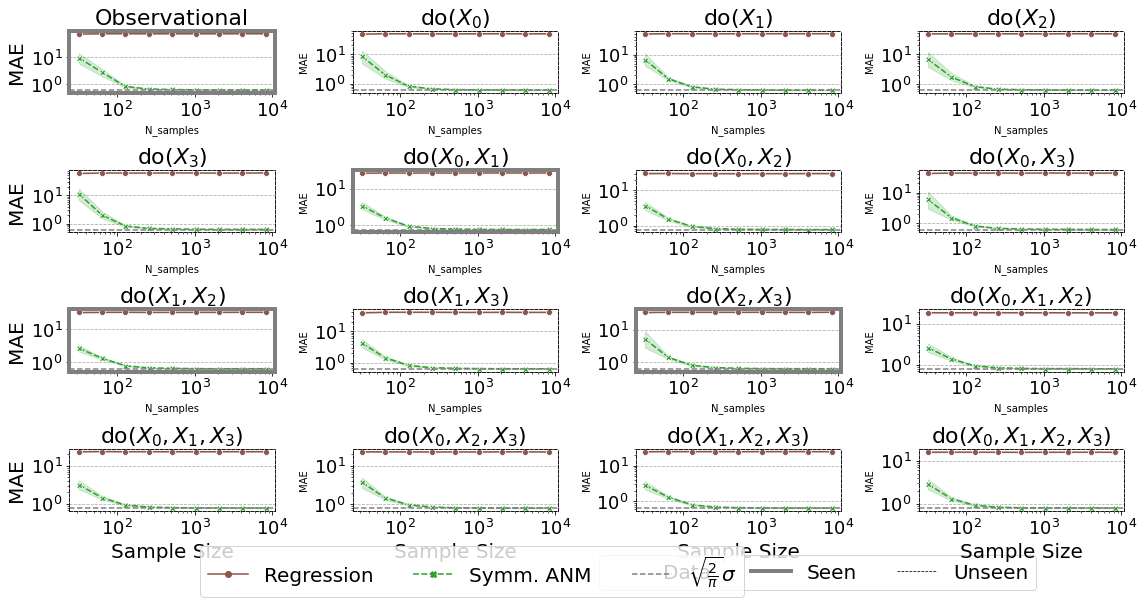

In [21]:
from matplotlib.patches import Patch, Rectangle
from matplotlib.lines import Line2D
fig, axes = plt.subplots(figsize=(16, 8), nrows=4, ncols=4) #, sharex='col', sharey='row')

i = 0
for ax, (interventions, results_df) in zip(axes.flatten(),interventions_to_results.items()):
    
    
    results_df = results_df.reset_index(drop=True)
    
    title = 'Observational'
    if interventions:
        title = r'do($' + ','.join([f'X_{k}' for k in interventions]) +'$)'
    ax.set_title(title, fontsize=22)
    l = sns.lineplot(data=results_df, x="N_samples", y="MAE", hue="Model", style="Model", markers=True, ax=ax, legend = 'brief' if i == 15 else False, palette=[tableau20[10],tableau20[4]])
    if len(interventions) < n_dim-1:
        exp_div = expected_deviation(act_cov, interventions)
    else:
        exp_div = np.sqrt(2.0/np.pi)
    ax.axhline(exp_div,ls='--', color='gray', label=r'$\sqrt{\frac{2}{\pi}}\sigma$')
   
    if i == 15:
        ax.legend(fontsize=20, ncol=4, bbox_to_anchor=(-.8,-0.4))

    ax.set_xscale('log')
    ax.set_yscale('log')
    
    ax.tick_params(axis='x', labelsize=18)
    ax.tick_params(axis='y', labelsize=18)
    
    if i > 11:
        ax.set_xlabel('Sample Size', fontsize=20)
    if i % 4 == 0:
        ax.set_ylabel('MAE', fontsize=20)

    
    if i in [0, 5, 8, 10]:
        [j.set_linewidth(4) for j in ax.spines.values()]
        [j.set_color(tableau20[14]) for j in ax.spines.values()]
    else:
        pass
        [j.set_linestyle("dashed") for j in ax.spines.values()]
        [j.set_linewidth(.9) for j in ax.spines.values()]
    
    ax.yaxis.grid(True, linestyle =  '--')
    ax.set_axisbelow(True)
    
    i += 1

    plt.tight_layout()

legend_elements = [Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0, label='Data'), Line2D([0], [0], c=tableau20[14], lw=4, label='Seen'), Line2D([0], [0], c='black', lw=.75, ls='dashed',  label='Unseen')]
axes.flatten()[-2].legend(handles=legend_elements, fontsize=20, ncol=3, bbox_to_anchor=(2.0,-0.55))    

plt.show()

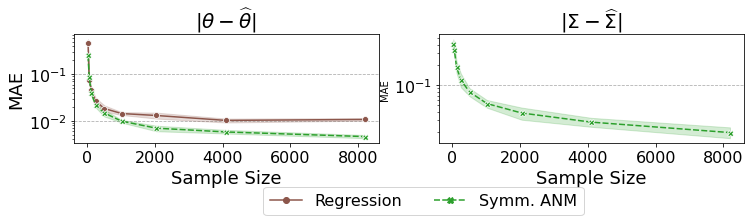

In [22]:
from matplotlib.patches import Patch, Rectangle
from matplotlib.lines import Line2D

param_df=param_df.reset_index(drop=True)
cov_df=cov_df.reset_index(drop=True)

fig, axes = plt.subplots(figsize=(12, 2), ncols=2) #, sharey='row')

axes[0].set_title(r'$|\theta - \widehat{\theta}|$', fontsize=20)
l = sns.lineplot(data=param_df, x="N_samples", y="MAE", hue="Model", style="Model", markers=True, ax=axes[0], legend=False, palette=[tableau20[10],tableau20[4]])
axes[0].set_yscale('log')
axes[0].tick_params(axis='x', labelsize=16)
axes[0].tick_params(axis='y', labelsize=16)
axes[0].set_xlabel('Sample Size', fontsize=18)
axes[0].set_ylabel('MAE', fontsize=18)

axes[1].set_title(r'$|\Sigma - \widehat{\Sigma}|$', fontsize=20)
l = sns.lineplot(data=cov_df, x="N_samples", y="MAE", hue="Model", style="Model", markers=True, ax=axes[1], palette=[tableau20[10],tableau20[4]])
axes[1].set_yscale('log')
axes[1].tick_params(axis='x', labelsize=16)
axes[1].tick_params(axis='y', labelsize=16)
axes[1].set_xlabel('Sample Size', fontsize=18)

axes[1].legend(fontsize=16, ncol=3, bbox_to_anchor=(.5,-.33))
axes[0].yaxis.grid(True, linestyle =  '--')
axes[0].set_axisbelow(True)
axes[1].yaxis.grid(True, linestyle =  '--')
axes[1].set_axisbelow(True)

plt.show()

In [23]:
str(datetime.now())

'2022-05-19 14:24:37.716795'